# Exercise 2

## Fundamentals of Machine Learning

#### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl

#### Version information:
        2020-12-07: v.1.0. First public release. 


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn import model_selection

from scipy.stats import multivariate_normal

## 3 - Data Preparation
We filter the full digits dataset such that only the digits "1" and "7" are left. Of the remaining 361 instances, we split these up into a training and test set with proportions 3 to 2 respectively.

In [2]:
# Import the digits dataset
digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

# Filter out ones and sevens from the dataset.
mask = (target == 1) | (target == 7)
data_filtered   = data[mask,:]
target_filtered = target[mask]

# Create training and test sets, only containing ones and sevens.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
X_train.shape[0]/X_test.shape[0]

1.4896551724137932

### 3.1 - Dimension reduction (3 pts)
We use a simple minded approach of looking at the average images of each class and finding two pixels that have the largest difference in the average pixel values. These two pixels should theoretically best characterise and differentiate each class from one another.

[19 60]


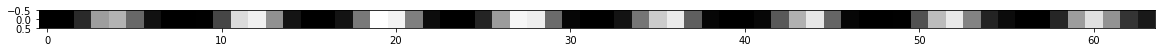

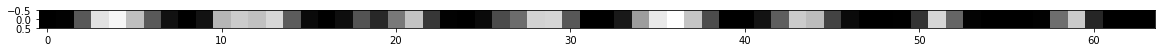

In [4]:
mask_ones     = (target == 1) 
mask_sevens   = (target == 7)
data_ones   = data[mask_ones,:]
data_sevens = data[mask_sevens,:]

data_avg_one   = np.average(data_ones, axis=0)
data_avg_seven = np.average(data_sevens, axis=0)

pixel_candidates =  np.argsort(-np.abs(data_avg_one-data_avg_seven))[:2]
print(pixel_candidates)

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_one[None,:], interpolation="nearest")
plt.show()

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_seven[None,:], interpolation="nearest")
plt.show()

So, the pixels with the flattened indices 19 and 60 are the two pixels with the largest differences between the two class averages. These linear indices corresponds to 2D indicies (3,2) and (4,7). We plot in 2d to confirm that our choice of pixels makes sense. 

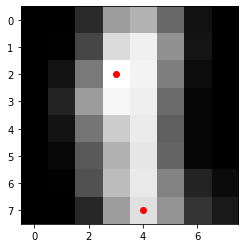

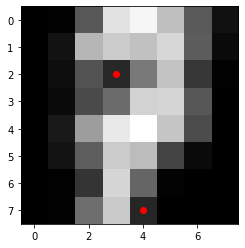

In [5]:
images_ones   = images[mask_ones,:,:]
images_sevens = images[mask_sevens,:,:]

img_avg_one   = np.average(images_ones, axis=0)
img_avg_seven = np.average(images_sevens, axis=0)

x = pixel_candidates % 8
y = pixel_candidates // 8

plt.figure()
plt.gray()
plt.imshow(img_avg_one, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

plt.figure()
plt.gray()
plt.imshow(img_avg_seven, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

Thus, we implement an function to reduce the number of dimensions from 64 to 2. This is done by only considering the pixel values in each of these two pixels for each instance. Effectivley, only these two feature dimensions are considered henceforth, all others are ignored.

In [6]:
def reduce_dim(x):
    return x[:,pixel_candidates]

### 3.2 - Scatterplot (4 pts)

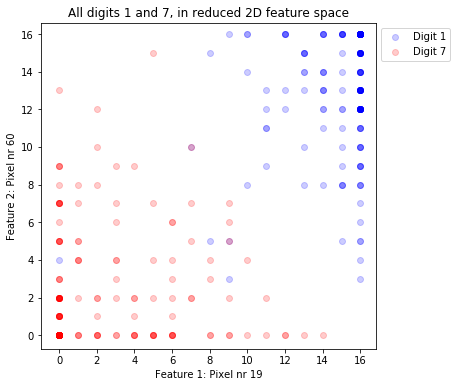

In [7]:
reduced_ones   = reduce_dim(data_ones)
reduced_sevens = reduce_dim(data_sevens)

plt.figure(figsize=(6,6))
plt.scatter(reduced_ones[:,0], reduced_ones[:,1], c="b", alpha=0.2, label='Digit 1')
plt.scatter(reduced_sevens[:,0], reduced_sevens[:,1], c="r", alpha=0.2,label='Digit 7')
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('Feature 1: Pixel nr 19')
plt.ylabel('Feature 2: Pixel nr 60')
plt.title('All digits 1 and 7, in reduced 2D feature space', fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

## 4 - Nearest Mean
### 4.1 - Implement the Nearest Mean Classifier (3 pts)
Find the mean of the 2D feature vectors of each class in the training set and assign the label of its nearest mean to test each test instance.

In [8]:
def nearest_mean(training_features, training_labels, test_features):
    """
    Implementation of the nearest mean classifier. The training features used as input 
    must be outputs from the reduce_dim() function.
    
    params
    ------
    training_features: np.array
        Matrix of shape (N,2), where N is the number of training instances.
    training_labels: np.array
        Matrix of shape (N,), where N is the number of training instances.
    test_features: np.array
        Matrix of shape (M,2), where M is the number of test instances. 

    returns
    -------
    np.array shape=(M,)
        Predicted labels for the test features, given the training set.
    """
    # Find all classes in the training set.
    unique_labels = np.unique(training_labels)

    # Calculate the 2D mean in feature space for each class independently.
    mu = np.zeros((unique_labels.shape[0], 2))
    for idx, label in enumerate(unique_labels):
        mu[idx] = np.average(training_features[training_labels == label], axis=0)

    # For each test instance, find the distances to all class means.
    dist = np.linalg.norm(test_features[:,None]-mu, axis=2)

    # Find the label of the closest class mean for each test instance.
    predicted_labels = unique_labels[np.argmin(dist, axis=1)]

    return predicted_labels, mu

### 4.2 - Visualize the decision regions (4 pts)

In [9]:
# Create the reduced test and training sets.
X_train_red = reduce_dim(X_train)
X_test_red  = reduce_dim(X_test)

# Prectict labels using the Nearest Mean Method.
predicted_labels, mu = nearest_mean(X_train_red, y_train, X_test_red)

# (Not needed) Calculate error rate of the predictions.
error_rate = np.sum(predicted_labels != y_test)/y_test.shape[0]
print(error_rate)

0.006896551724137931


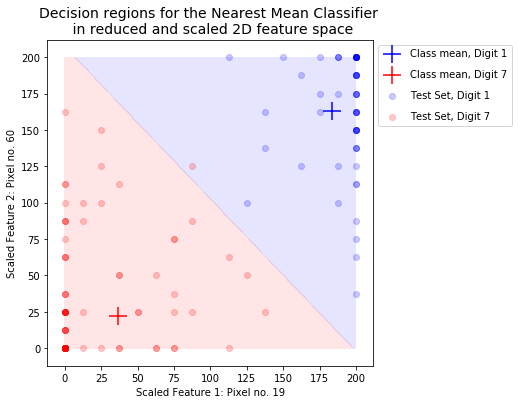

In [10]:
# Function to transform points in 2d feature space [0,16]^2 to a 200x200 gridspace.
def transform(X_reduced):
    return 12.5*X_reduced

# Transform test and train data to grid space.
X_train_scaled  = transform(X_train_red)
X_test_scaled   = transform(X_test_red)
mu_scaled       = transform(mu)

# Create figure.
plt.figure(figsize=(6,6))

# Visualize the descision regions.
x    = np.linspace(0, 200, 1000)
X, Y = np.meshgrid(x, x)
pos  = np.dstack((X, Y))
dist_to_one   = np.linalg.norm(pos-mu_scaled[0,:], axis=2)
dist_to_seven = np.linalg.norm(pos-mu_scaled[1,:], axis=2)
Z = (dist_to_seven - dist_to_one) > 0
plt.contourf(X, Y, Z, alpha=0.1, colors=["red", "blue"], levels=1)

# Plot the class means
plt.scatter(mu_scaled[0,0], mu_scaled[0,1], marker='+', s=300, color='b', label='Class mean, Digit 1')
plt.scatter(mu_scaled[1,0], mu_scaled[1,1], marker='+', s=300, color='r', label='Class mean, Digit 7')

# Plot the test set
mask1 = y_test == 1
mask7 = y_test == 7
plt.scatter(X_test_scaled[mask1,0], X_test_scaled[mask1,1], c="b", alpha=0.2, label='Test Set, Digit 1')
plt.scatter(X_test_scaled[mask7,0], X_test_scaled[mask7,1], c="r", alpha=0.2, label='Test Set, Digit 7')

# General plot settings
plt.axes().set_aspect('equal')
plt.xlabel('Scaled Feature 1: Pixel no. 19')
plt.ylabel('Scaled Feature 2: Pixel no. 60')
plt.title('Decision regions for the Nearest Mean Classifier \n in reduced and scaled 2D feature space', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', labelspacing=1.1, fontsize=10)
plt.show()

## 5 - QDA
### 5.1 - Implement QDA Training (6 pts)

In [11]:
def fit_qda(training_features, training_labels):
    """
    Implementation of Quadratic Discriminant Analysis.
    
    Parameters
    ----------
    training_features: array_type
        Matrix of shape (N,D) with N training instances, each with features in D dimensions. 
    training_labels: array_type
        Vector of shape (N,), with N labels corresponding to training_features.

    Returns
    -------
    mu: array_type
        Maxtrix of shape (C,D) where each row correspond to the class mean in D dimensions, 
        for the C unique classes in training_labels.
    covmat: array_type
        Matrix of shape (C,D,D) containing C-by-C covariance matricies for each of the C
        unique classes in training_labels.
    p: array_type
        Vector of shape (C,) containing the C priors for each unique class.
    unique_labels: array_type
        Vector of shape (C,) containing the names of the C unique labels, ordering corresponding
        to the other outputs mu, covmat and p.
    """
    # Find number of unique classes, and their labels.
    unique_labels = np.sort(np.unique(training_labels))
    C = unique_labels.shape[0] 

    # Number of training instances and dimensions in feature space.
    N,D = training_features.shape

    # Pre-allocations.
    mu     = np.zeros((C,D))
    covmat = np.zeros((C,D,D))
    p      = np.zeros(C)

    # Calculate class means, covariance matricies and prior probabilities.
    for i, label in enumerate(unique_labels):
        mask = training_labels == label

        mu[i] = np.mean(training_features[mask], axis=0)

        x_mu = training_features[mask]-mu[i] 
        covmat[i] = np.mean(x_mu[...,None]*x_mu[:,None], axis=0)

        p[i] = np.sum(mask)/N

    return mu, covmat, p, unique_labels

### 5.2 Implement QDA Prediction (3 pts)

In [12]:
def predict_qda(mu, covmat, p, test_features):
    """
    Implementation of Quadratic Discriminant Analysis.
    
    Parameters
    ----------
    mu: array_type
        Maxtrix of shape (C,D) where each row correspond to the class mean in D dimensions, 
        for the C unique classes.
    covmat: array_type
        Matrix of shape (C,D,D) containing C-by-C covariance matricies for each of the C
        unique classes in training_labels.
    p: array_type
        Vector of shape (C,) containing the C priors for each unique class.
    test_features: array_type
        Matrix of shape (M,D) with M test instances in D dimensional feature space. 

    Returns
    -------
    predicted_labels: array_type
        Maxtrix of shape (M,) containing the predicted labels for each test instance.
    """

    b = 0.5*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p)   # (C,) vector. one b for each class

    0.5 * (test_features- 

    return predicted_labels 

SyntaxError: invalid syntax (<ipython-input-12-bc881a400598>, line 28)

In [18]:
mu, covmat, p, unique_labels = fit_qda(X_train,y_train)
covmat.shape
mu.shape

(2, 64)

In [17]:
np.linalg.inv(covmat)

array([[[ 0.18881406, -0.0469393 ],
        [-0.0469393 ,  0.10968282]],

       [[ 0.07356308, -0.00446677],
        [-0.00446677,  0.12709312]]])

In [64]:
print(X_test[:,None].shape)
print(mu.shape)

(145, 1, 64)
(2, 64)


In [69]:
(X_test[:,None]-mu).shape

(145, 2, 64)

In [23]:
covmat.shape

(2, 64, 64)

In [25]:
(X_test[:,None]-mu) @ 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 64)

In [26]:
covmat.transpose(1,0,2).shape

(64, 2, 64)

In [28]:
np.tensordot?

Signature: np.tensordot(a, b, axes=2)
Docstring:
Compute tensor dot product along specified axes.

Given two tensors, `a` and `b`, and an array_like object containing
two array_like objects, ``(a_axes, b_axes)``, sum the products of
`a`'s and `b`'s elements (components) over the axes specified by
``a_axes`` and ``b_axes``. The third argument can be a single non-negative
integer_like scalar, ``N``; if it is such, then the last ``N`` dimensions
of `a` and the first ``N`` dimensions of `b` are summed over.

Parameters
----------
a, b : array_like
    Tensors to "dot".

axes : int or (2,) array_like
    * integer_like
      If an int N, sum over the last N axes of `a` and the first N axes
      of `b` in order. The sizes of the corresponding axes must match.
    * (2,) array_like
      Or, a list of axes to be summed over, first sequence applying to `a`,
      second to `b`. Both elements array_like must be of the same length.

Returns
-------
output : ndarray
    The tensor dot product of

In [29]:
np.linalg.

Signature: np.diag(v, k=0)
Docstring:
Extract a diagonal or construct a diagonal array.

See the more detailed documentation for ``numpy.diagonal`` if you use this
function to extract a diagonal and wish to write to the resulting array;
whether it returns a copy or a view depends on what version of numpy you
are using.

Parameters
----------
v : array_like
    If `v` is a 2-D array, return a copy of its `k`-th diagonal.
    If `v` is a 1-D array, return a 2-D array with `v` on the `k`-th
    diagonal.
k : int, optional
    Diagonal in question. The default is 0. Use `k>0` for diagonals
    above the main diagonal, and `k<0` for diagonals below the main
    diagonal.

Returns
-------
out : ndarray
    The extracted diagonal or constructed diagonal array.

See Also
--------
diagonal : Return specified diagonals.
diagflat : Create a 2-D array with the flattened input as a diagonal.
trace : Sum along diagonals.
triu : Upper triangle of an array.
tril : Lower triangle of an array.

Examples

In [33]:
a = np.arange(1,28).reshape(3,3,3)
print(a)
np.einsum('iii->i', a)

[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]]


array([ 1, 14, 27])